In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, rc={'figure.figsize': (20, 15), "figure.dpi": 100, "savefig.dpi": 100})
sns.set_style("darkgrid")

In [101]:
data = pd.read_csv('data/dataset.csv')
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")
data.set_index('date', inplace=True)

In [102]:
stats = data.describe()
stats.loc['skew'] = data.skew().tolist()
stats.loc['kurt'] = data.kurtosis().tolist()
stats

,price,demand,generation_coal,generation_diesel,generation_gas,generation_geo,generation_hydro,generation_wind,generation_wood,cloudcover,dew,humidity,precip,precipcover,solarenergy,temp,winddir,windspeed
count,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,100.569646,20980.063938,3818.922010,12.598392,15193.888944,19944.658071,66339.230811,5321.149008,681.485585,53.922357,9.190771,79.972138,3.099663,8.929866,15.063008,12.865396,201.107166,28.433654
std,70.509956,1862.658455,3664.952344,80.918839,5007.137430,1462.082847,8705.602119,2717.717648,246.182035,16.164405,3.308243,5.548270,3.638905,5.516833,7.754738,3.577091,59.262319,6.743033
min,0.016808,15468.521200,0.000000,0.000000,1753.844000,13436.056323,38516.216832,186.309891,0.000000,9.053024,0.092167,62.852095,0.000000,0.000000,1.308381,4.167548,34.453952,12.451976
25%,55.517461,19698.108575,0.000000,0.000000,11765.739975,19365.412617,60445.832117,3153.795119,661.006500,41.683506,6.759679,76.192119,0.671309,4.637363,7.955679,9.932024,157.785024,23.506482
50%,79.132532,20999.210400,3465.956500,0.000000,14755.118530,20317.658681,66485.942745,4994.229307,778.870000,53.578988,9.032762,80.084393,1.910983,8.410038,14.167190,12.690119,205.337369,27.599750
75%,123.057582,22160.136650,5481.356250,0.000000,18566.258120,20914.497774,72400.887920,7357.672952,834.107500,65.623655,11.661095,83.975798,4.126609,12.396362,21.469732,15.813262,245.807357,32.733911
max,1216.117213,27022.325700,17213.768000,1895.695000,30956.428640,22967.320000,93199.082000,14736.434000,931.137000,97.552333,18.514595,94.739143,36.750307,47.231779,33.975381,21.726524,334.999500,56.459238
skew,2.888983,0.065995,0.988345,11.141217,0.210042,-1.233601,-0.079656,0.427651,-1.723990,0.067310,0.046727,-0.157033,2.665342,0.831280,0.333476,0.071250,-0.239384,0.589065
kurt,23.025562,-0.213533,0.765612,163.854196,-0.026651,1.659903,-0.161182,-0.386208,1.889052,-0.595559,-0.612546,-0.384720,11.308852,1.867591,-1.074538,-0.916966,-0.631905,0.187883


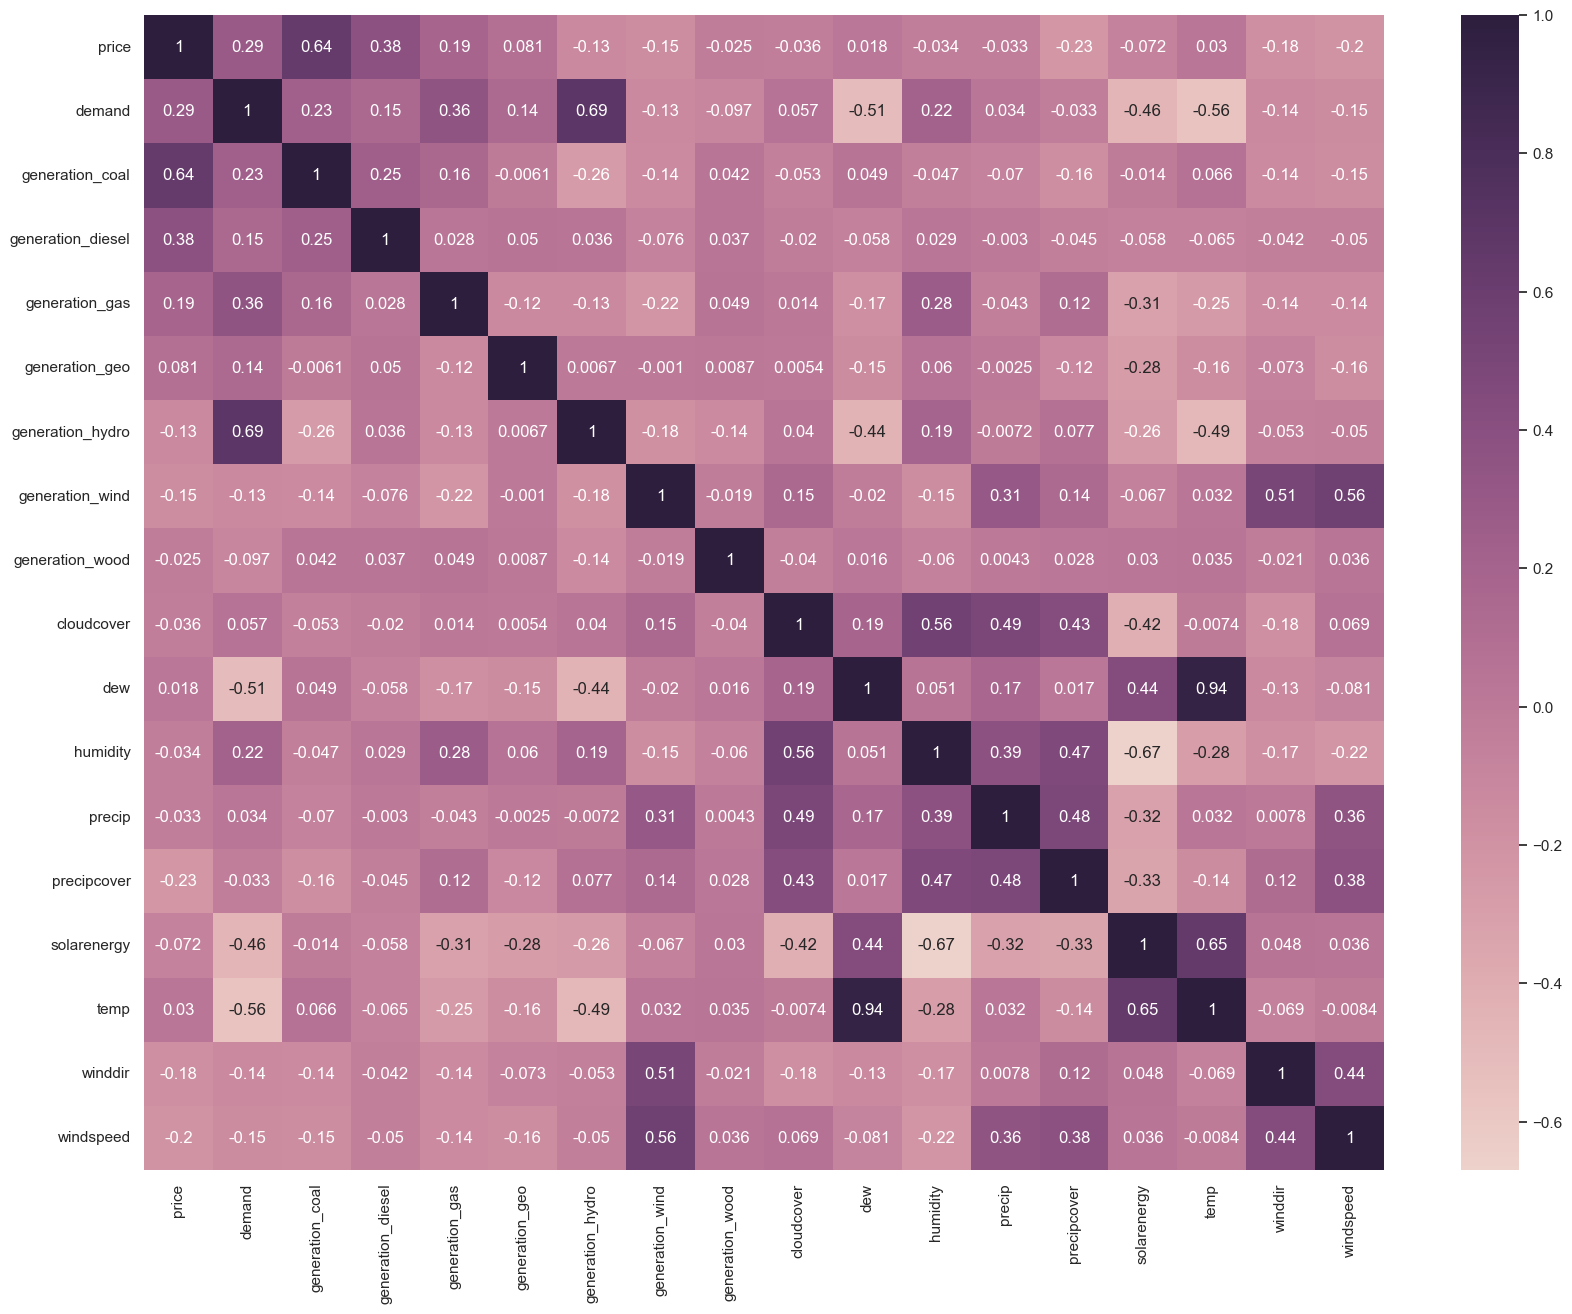

In [105]:
sns.heatmap(data.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True));